# Forecast class
This class deals with weather forecasts and uses CLIMADA ImpactCalc.impact() to forecast impacts of weather events on society. It mainly does one thing:
- it contains all plotting and other functionality that are specific for weather forecasts, impact forecasts and warnings

The class is different from the Impact class especially because features of the Impact class like Exceedence frequency curves, annual average impact etc, do not make sense if the hazard is e.g. a 5 day weather forecast. As the class is relatively new, there might be future changes to the datastructure, the methods, and the parameters used to call the methods.

## Example: forecast of building damages due to wind in Switzerland
Before using the forecast class, hazard, exposure and vulnerability need to be created. The hazard looks at the weather forecast from today for an event with two days lead time (meaning the day after tomorrow). generate_WS_forecast_hazard is used to download a current weather forecast for wind gust from opendata.dwd.de. An Impact funtion for building damages due to storms is created. And with only a few lines of code, a LitPop exposure for Switzerland is generated,  and the impact is calculated with a default impact function. With a further line of code, the mean damage per grid point for the day after tomorrow is plotted on a map.

In [1]:
from datetime import datetime
from cartopy import crs as ccrs

from climada.util.config import CONFIG
from climada.engine.forecast import Forecast
from climada.hazard.storm_europe import StormEurope, generate_WS_forecast_hazard
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity import ImpactFuncSet
from climada.entity import LitPop

In [2]:
#generate hazard
hazard, haz_model, run_datetime, event_date = generate_WS_forecast_hazard()
# #generate hazard with with forecasts from past dates (works only if the files have already been downloaded)
# hazard, haz_model, run_datetime, event_date = generate_WS_forecast_hazard(
#     run_datetime=datetime(2022,5,17),
#     event_date=datetime(2022,5,19)) 

In [3]:
#generate vulnerability
impact_function = ImpfStormEurope.from_welker()
impact_function_set = ImpactFuncSet()
impact_function_set.append(impact_function)

In [4]:
#generate exposure and save to file
filename_exp = CONFIG.local_data.save_dir.dir() / ('exp_litpop_Switzerland.hdf5')
if filename_exp.exists():
    exposure = LitPop.from_hdf5(filename_exp)
else:
    exposure = LitPop.from_countries('Switzerland', reference_year=2020)
    exposure.write_hdf5(filename_exp)

In [5]:
#create and calculate Forecast
CH_WS_forecast = Forecast({run_datetime: hazard}, exposure, impact_function_set)
CH_WS_forecast.calc()

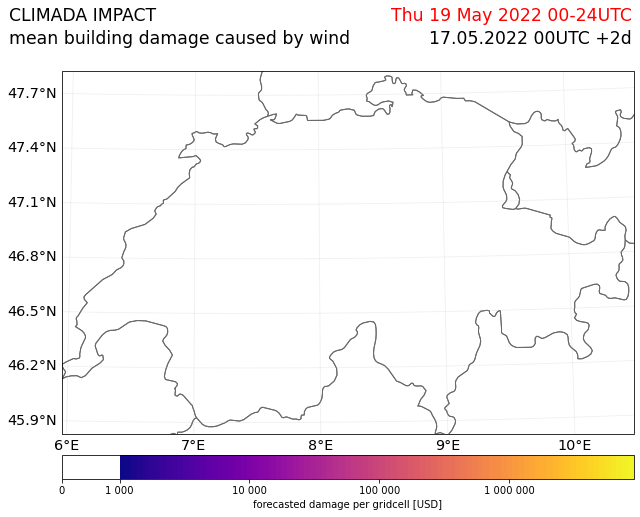

In [6]:
CH_WS_forecast.plot_imp_map(save_fig=False,close_fig=False,proj=ccrs.epsg(2056));

Here you see a different plot highlighting the spread of the impact forecast calculated from the different ensemble members of the weather forecast.

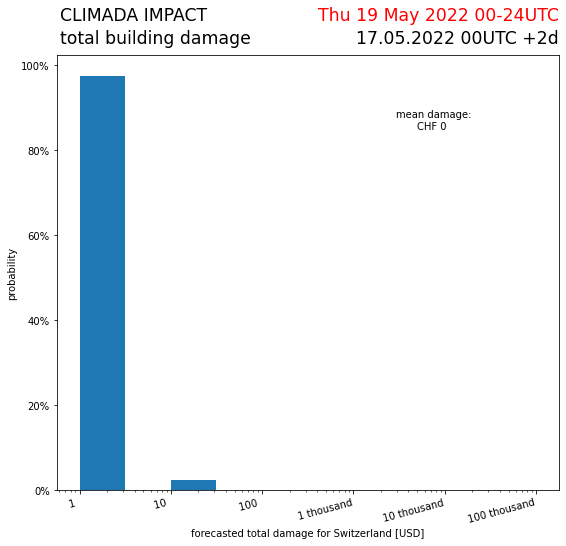

In [7]:
CH_WS_forecast.plot_hist(save_fig=False,close_fig=False);

It is possible to color the pixels depending on the probability that a certain threshold of impact is reach at a certain grid point

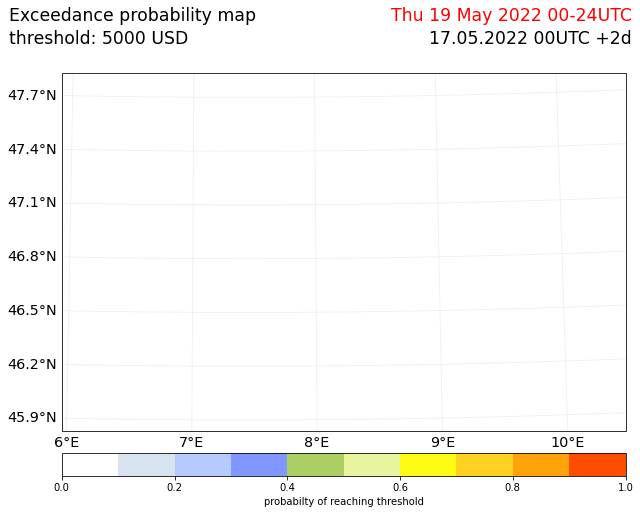

In [8]:
CH_WS_forecast.plot_exceedence_prob(threshold=5000, save_fig=False, close_fig=False,proj=ccrs.epsg(2056));

It is possible to color the cantons of Switzerland with warning colors, based on aggregated forecasted impacts in their area.

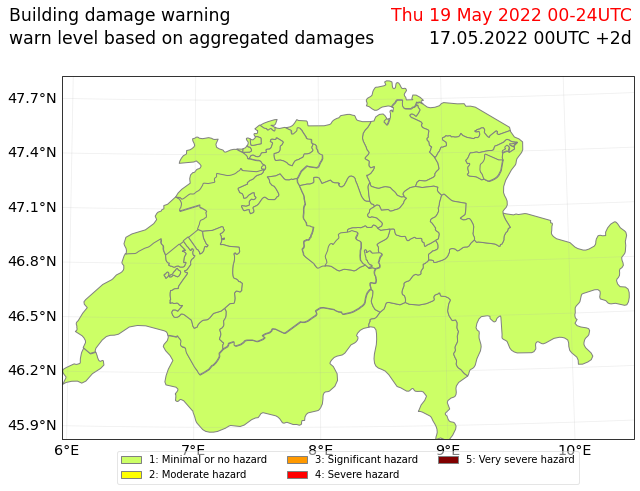

In [9]:
import fiona
from cartopy.io import shapereader
from climada.util.config import CONFIG


#create a file containing the polygons of Swiss cantons using natural earth
cantons_file = CONFIG.local_data.save_dir.dir() / 'cantons.shp'
adm1_shape_file = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_1_states_provinces')
if not cantons_file.exists():
    with fiona.open(adm1_shape_file, 'r') as source:
        with fiona.open(
                cantons_file, 'w',
                **source.meta) as sink:

            for f in source:
                if f['properties']['adm0_a3'] == 'CHE':
                    sink.write(f)
CH_WS_forecast.plot_warn_map(str(cantons_file),
                             decision_level = 'polygon',
                             thresholds=[100000,500000,
                                         1000000,5000000],
                             probability_aggregation='mean',
                             area_aggregation='sum',
                             title="Building damage warning",
                             explain_text="warn level based on aggregated damages",
                             save_fig=False,
                             close_fig=False,
                             proj=ccrs.epsg(2056));

## Example 2: forecast of wind warnings in Switzerland
Instead of a fully fledged socio-economic impact of storms, one can also simplify the hazard, exposure, vulnerability model, by looking at a "neutral" exposure (=1 at every gridpoint) and using a step function as impact function to arrive at warn levels. It also shows how the attributes hazard, exposure or vulnerability can be set before calling calc(), and are then considered in the forecast instead of the defined defaults.

In [10]:
from pandas import DataFrame
import numpy as np
from climada.entity.exposures import Exposures
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet
import climada.util.plot as u_plot

### generate exposure
# find out which hazard coord to consider
CHE_borders = u_plot._get_borders(np.stack([exposure.gdf.latitude.values,
                                            exposure.gdf.longitude.values],
                                           axis=1)
                                 )
centroid_selection = np.logical_and(np.logical_and(hazard.centroids.lat >= CHE_borders[2],
                                                   hazard.centroids.lat <= CHE_borders[3]),
                                    np.logical_and(hazard.centroids.lon >= CHE_borders[0],
                                                   hazard.centroids.lon <= CHE_borders[1])
                                   )
# Fill DataFrame with values for a "neutral" exposure (value = 1)

exp_df = DataFrame()
exp_df['value'] = np.ones_like(hazard.centroids.lat[centroid_selection]) # provide value
exp_df['latitude'] = hazard.centroids.lat[centroid_selection]
exp_df['longitude'] = hazard.centroids.lon[centroid_selection]
exp_df['impf_WS'] = np.ones_like(hazard.centroids.lat[centroid_selection], int)
# Generate Exposures
exp = Exposures(exp_df)
exp.check()
exp.value_unit = 'warn_level'

### generate impact functions
## impact functions for hazard based warnings
haz_type = 'WS'
idx = 1
name = 'warn_level_low_elevation'
intensity_unit = 'm/s'
intensity = np.array([0.0, 19.439, 
                      19.44, 24.999, 
                      25.0, 30.549, 
                      30.55, 38.879, 
                      38.88, 100.0])
mdd = np.array([1.0, 1.0, 
                2.0, 2.0, 
                3.0, 3.0, 
                4.0, 4.0, 
                5.0, 5.0])
paa = np.ones_like(mdd)
imp_fun_low = ImpactFunc(haz_type, idx, intensity, mdd, paa, intensity_unit, name)
imp_fun_low.check()
# fill ImpactFuncSet
impf_set = ImpactFuncSet()
impf_set.append(imp_fun_low)

2022-05-17 09:07:44,196 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


In [11]:
#create and calculate Forecast
warn_forecast = Forecast({run_datetime: hazard}, exp, impf_set)
warn_forecast.calc()

The each grid point now has a warnlevel between 1-5 assigned for each event. Now the  cantons can be colored based on a threshold on a grid point level. for each warning level it is assessed if 50% of grid points in the area of a canton has at least a 50% probability of reaching the specified threshold.

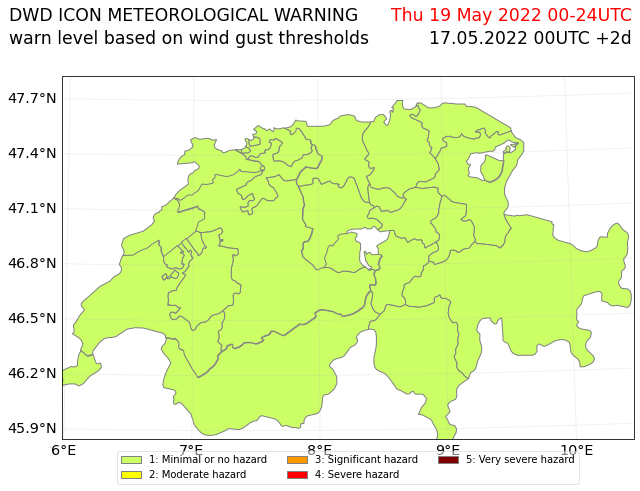

In [12]:
warn_forecast.plot_warn_map(cantons_file,
                            thresholds=[2,3,4,5],
                            decision_level = 'exposure_point',
                            probability_aggregation=0.5,
                            area_aggregation=0.5,
                            title="DWD ICON METEOROLOGICAL WARNING",
                            explain_text="warn level based on wind gust thresholds",
                            save_fig=False,
                            close_fig=False,
                            proj=ccrs.epsg(2056));

## Example: Tropical Cylcone
It would be nice to add an example using the tropical cyclone forecasts from the class TCForecast. This has not yet been done.